# Running a REopt API evaluation

## Steps to Get Set Up
1. Go to https://colab.research.google.com/
2. Open a new Colab notebook by linking to this GitHub repository with the URL: https://github.com/NREL/REopt-Analysis-Scripts.git
3. Choose this file "google_colab_simple_examples.ipynb" from the list of options

## Initialization

In [1]:
# Clone the REopt-Analysis-Scripts GitHub Repository to this Google Colab Notebook
!git clone -l -s https://github.com/NREL/REopt-Analysis-Scripts.git cloned-repo
%cd cloned-repo

# Change directory to "REopt API Scripts" folder
%cd "REopt API Scripts"

# Print contents
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 1160, done.
remote: Counting objects: 100% (396/396), done.
remote: Compressing objects: 100% (204/204), done.
remote: Total 1160 (delta 264), reused 250 (delta 192), pack-reused 764 (from 1)
Receiving objects: 100% (1160/1160), 19.89 MiB | 5.59 MiB/s, done.
Resolving deltas: 100% (717/717), done.
/content/cloned-repo
/content/cloned-repo/REopt API Scripts
archived_v2_scripts  inputs	    outputs			   src
electric_rates	     load_profiles  single_scenario_example.ipynb


In [2]:
import pandas as pd
import numpy as np
import json
import requests
import copy
import os
from src.post_and_poll import get_api_results
import matplotlib.pyplot as plt
API_KEY = '7vZ12k2wwtIzYdR4nHAHrLvdwv3NmMMkumcfnjyQ'  # REPLACE WITH YOUR API KEY

In [3]:
# following is not necessary but silences warnings:
# InsecureRequestWarning: Unverified HTTPS request is being made to host 'developer.nrel.gov'. Adding certificate verification is strongly advised.
import urllib3
urllib3.disable_warnings()

In [4]:
"""
File paths
"""
##############################################################################################################
inputs_path = os.path.join(".", 'inputs')
outputs_path = os.path.join(".", 'outputs')
loads_path = os.path.join(".", 'load_profiles')
rates_path = os.path.join(".", 'electric_rates')
##############################################################################################################

## Scenario Inputs (POST), if wanting to do a new API call

- View all possible inputs, default values, and explanations, here: https://nrel.github.io/REopt.jl/dev/reopt/inputs/
- Defaults will be used for any input not supplied


In [ ]:
post = {
    "Site": {
        # Location of site
        "latitude": 50.44534458236023,
        "longitude": 30.529943967917802,
        # Area available
        "land_acres": 1,
        "roof_squarefeet": 5000
    },
    "PV": {
        # Modify PV cost (fully-installed cost)
        "installed_cost_per_kw": 800.0
    },
    # Supply a blank dictionary to evaluate the technology without chaning any defaults
    "ElectricStorage" : {},
    "ElectricLoad": {
        # Define building type and annual load - to use modeled loads from DOE Commercial Reference Buildings
        "doe_reference_name": "RetailStore",
        "annual_kwh": 100000.0
    },
    "ElectricTariff": {
        # Average energy and demand charges, applied monthly
        "blended_annual_energy_rate": 0.20,
        "blended_annual_demand_rate": 5
    },
    "ElectricUtility" : {
        # Specify grid emissions factor
        "emissions_factor_series_lb_CO2_per_kwh": 1.04
    },
    "Financial": {
        # Define financial parameters
        "elec_cost_escalation_rate_fraction": 0.05,
        "offtaker_discount_rate_fraction": 0.13,
        "analysis_years": 20,
        "offtaker_tax_rate_fraction": 0.18,
        "om_cost_escalation_rate_fraction": 0.025
    }
}

## POST and poll (periodic GET request) the API to GET the REopt results. This can take a while!

`get_api_results` POST's your inputs to the API `job` endpoint, which provides a `run_uuid` if the input is valid, and then polls the `results` endpoint using the `run_uuid` until the results come back with a status other than `Optimizing...`.

`get_api_results` also saves the results (full API response, including inputs) to the `results_file`.

In [ ]:
outputs_file_name = "my_results_file"
root_url = "https://developer.nrel.gov/api/reopt/stable" # /stable == /v3

api_response = get_api_results(post=post,
                               API_KEY=API_KEY,
                               api_url=root_url,
                               results_file=os.path.join(outputs_path, outputs_file_name + ".json"),
                               run_id=None)

main         INFO     Response OK from https://developer.nrel.gov/api/reopt/stable/job/?api_key=7vZ12k2wwtIzYdR4nHAHrLvdwv3NmMMkumcfnjyQ.
INFO:main:Response OK from https://developer.nrel.gov/api/reopt/stable/job/?api_key=7vZ12k2wwtIzYdR4nHAHrLvdwv3NmMMkumcfnjyQ.
main         INFO     Polling https://developer.nrel.gov/api/reopt/stable/job/53c12de0-37db-487b-bee2-635314801e8a/results/?api_key=7vZ12k2wwtIzYdR4nHAHrLvdwv3NmMMkumcfnjyQ for results with interval of 5s...
INFO:main:Polling https://developer.nrel.gov/api/reopt/stable/job/53c12de0-37db-487b-bee2-635314801e8a/results/?api_key=7vZ12k2wwtIzYdR4nHAHrLvdwv3NmMMkumcfnjyQ for results with interval of 5s...
main         INFO     Saved results to ./outputs/my_results_file.json
INFO:main:Saved results to ./outputs/my_results_file.json


## Explore API Response
- View all results fields here: https://nrel.github.io/REopt.jl/dev/reopt/outputs/

In [ ]:
# Keys within full response JSON
api_response.keys()

dict_keys(['run_uuid', 'api_version', 'user_uuid', 'webtool_uuid', 'job_type', 'status', 'created', 'reopt_version', 'api_key', 'portfolio_uuid', 'inputs', 'outputs', 'messages'])

In [ ]:
# Full inputs dictionary
api_response["inputs"];

# View just "Financial" inputs
api_response["inputs"]["Financial"]

{'analysis_years': 20,
 'elec_cost_escalation_rate_fraction': 0.05,
 'offtaker_discount_rate_fraction': 0.13,
 'offtaker_tax_rate_fraction': 0.18,
 'om_cost_escalation_rate_fraction': 0.025,
 'owner_discount_rate_fraction': 0.13,
 'owner_tax_rate_fraction': 0.18,
 'third_party_ownership': False,
 'value_of_lost_load_per_kwh': 0.0,
 'microgrid_upgrade_cost_fraction': 0.0,
 'offgrid_other_capital_costs': 0.0,
 'offgrid_other_annual_costs': 0.0,
 'CO2_cost_per_tonne': 51.0,
 'CO2_cost_escalation_rate_fraction': 0.042173,
 'NOx_grid_cost_per_tonne': 0.0,
 'SO2_grid_cost_per_tonne': 0.0,
 'PM25_grid_cost_per_tonne': 0.0,
 'NOx_onsite_fuelburn_cost_per_tonne': 0.0,
 'SO2_onsite_fuelburn_cost_per_tonne': 0.0,
 'PM25_onsite_fuelburn_cost_per_tonne': 0.0,
 'NOx_cost_escalation_rate_fraction': 0.0,
 'SO2_cost_escalation_rate_fraction': 0.0,
 'PM25_cost_escalation_rate_fraction': 0.0,
 'generator_fuel_cost_escalation_rate_fraction': 0.012,
 'existing_boiler_fuel_cost_escalation_rate_fraction': 0.

In [ ]:
# Output keys
print("Output Keys: ", list(api_response["outputs"].keys()))

Output Keys:  ['Financial', 'ElectricTariff', 'ElectricUtility', 'ElectricLoad', 'Site', 'PV', 'ElectricStorage']


In [ ]:
# Example: Calculate year one bill savings
year1_bill_optimized = api_response["outputs"]["ElectricTariff"]["year_one_bill_before_tax"] - api_response["outputs"]["ElectricTariff"]["year_one_export_benefit_before_tax"]
year1_bill_bau = api_response["outputs"]["ElectricTariff"]["year_one_bill_before_tax_bau"] - api_response["outputs"]["ElectricTariff"]["year_one_export_benefit_before_tax_bau"]
print("Year 1 Bill Savings ($): ", round(year1_bill_bau - year1_bill_optimized))

Year 1 Bill Savings ($):  8026


In [ ]:
# Good idea to view info messages and warnings.
api_response["messages"]

{'info': 'When using doe_reference_name or blended_doe_reference_names for ElectricLoad the year is set to 2017 because the DoE load profiles start on a Sunday.',
 'errors': {},
 'warnings': {'core_financial.jl_275': [' Could not look up EASIUR health cost escalation rates from point (50.44534458236023',
   '30.529943967917802). Location is likely invalid or outside the CAMx grid'],
  'core_electric_utility.jl_427': [' Your site location (50.44534458236023',
   ' 30.529943967917802) is more than 5 miles from the nearest AVERT region. Cannot calculate emissions.'],
  'core_financial.jl_245': [' Could not look up EASIUR health costs from point (50.44534458236023',
   '30.529943967917802). Location is likely invalid or outside the CAMx grid.',
   ' Could not look up EASIUR health costs from point (50.44534458236023',
   '30.529943967917802). Location is likely invalid or outside the CAMx grid.'],
  'core_doe_commercial_reference_building_loads.jl_57': [' Could not find latitudelongitude i

In [ ]:
# Summary of results
print("NPV ($) = ", api_response["outputs"]["Financial"]["npv"])
print("Capital Cost, Net ($) = ", api_response["outputs"]["Financial"]["lifecycle_capital_costs"])
tech_list = ["PV", "Wind", "ElectricStorage", "CHP", "Generator", "HotThermalStorage", "ColdThermalStorage", "AbsorptionChiller", "GHP", "Boiler", "SteamTurbine"]
for tech in tech_list:
    if tech in post.keys():
        if tech == "GHP":
            print("GHX Number of Boreholes = ", api_response["outputs"][tech]["ghpghx_chosen_outputs"].get("number_of_boreholes"))
            print("GHP Heat Pump Capacity (ton) = ", api_response["outputs"][tech]["ghpghx_chosen_outputs"].get("peak_combined_heatpump_thermal_ton"))
        for size_name_value in [(key, val) for key, val in api_response["outputs"][tech].items() if "size" in key]:
                print(tech + " " + size_name_value[0], " = ", size_name_value[1])

NPV ($) =  36538.55
Capital Cost, Net ($) =  23894.2041
PV size_kw  =  49.0344
ElectricStorage size_kw  =  0.0
ElectricStorage size_kwh  =  0.0


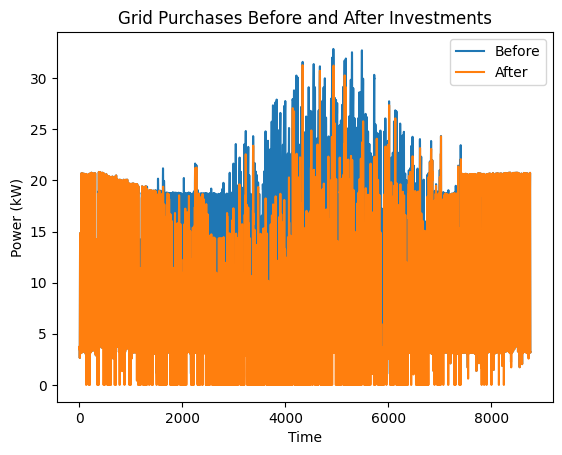

In [ ]:
# Choose some timeseries results to visualize
loads_kw = api_response["outputs"]["ElectricUtility"]["electric_to_load_series_kw_bau"]
electric_to_load_series_kw = api_response["outputs"]["ElectricUtility"]["electric_to_load_series_kw"]

plt.plot(loads_kw, label="Before")
plt.plot(electric_to_load_series_kw, label="After")

plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.title("Grid Purchases Before and After Investments")
plt.legend()
plt.show()

# Practice Exercises

## 1. Run a resilience evaluation

In [10]:
### Modify the values below for your test case before moving on ###

## Set the duration of the outage you wish to evaluate
outage_hours = 12

## Define your critical loads
# Option 1: Specify a percentage of the typical loads as critical
critical_load_fraction = 0.8 # 80%

# Option 2: Create a critical load profile and upload it to the "load_profiles" folder under the "Files" in this Colab space
# Uncomment if you wish to use this approach:
# critical_load_file_name = "my_file.csv"
# filepath = os.path.join(loads_path, critical_load_file_name)
# critical_loads_kw = pd.read_csv(filepath, header=None).iloc[:, 0].tolist()

## Specify the lat long
latitude = 50
longitude = 30

## Specify the building type and annual load
doe_reference_name = "Hospital" # See options here: https://nrel.github.io/REopt.jl/dev/reopt/inputs/#ElectricLoad
annual_kwh = 100000


In [11]:
# Just run this cell -- no modifications needed.
root_url = "https://developer.nrel.gov/api/reopt/stable"

# Get load profile
inputs = {"load_type": "electric",
        "doe_reference_name": doe_reference_name,
        "latitude": latitude,
        "longitude": longitude,
        "annual_kwh": annual_kwh
}
load_url = root_url + '/simulated_load/?api_key=' + API_KEY
response = requests.get(url=load_url, params=inputs, verify=False)
loads_kw = json.loads(response.content)["loads_kw"]

# Get outage start times. Assume outages occur during peak load times
inputs = {"seasonal_peaks": True,
          "outage_duration": outage_hours,
          "critical_load": loads_kw,
          "start_not_center_on_peaks": False
        }
times_url = root_url + '/peak_load_outage_times/?api_key=' + API_KEY
response = requests.post(url=times_url, json=inputs)
outage_times = json.loads(response.content)["outage_start_time_steps"]

In [12]:
### Modify any values below that are not already variables ###
### Check all possible inputs here: https://nrel.github.io/REopt.jl/dev/reopt/inputs/ ###

post = {
    "Site": {
        # Location of site
        "latitude": latitude,
        "longitude": longitude,
        # Area available
        "land_acres": 1,
        "roof_squarefeet": 5000
    },
    "PV": {
        # Modify PV cost (fully-installed cost)
        "installed_cost_per_kw": 800.0
    },
    # Supply a blank dictionary to evaluate the technology without chaning any defaults
    "ElectricStorage" : {},
    "ElectricLoad": {
        # Define building type and annual load - to use modeled loads from DOE Commercial Reference Buildings
        "doe_reference_name": doe_reference_name,
        "annual_kwh": annual_kwh
        # If using a custom load, you can specify loads_kw
    },
    "ElectricTariff": {
        # Average energy and demand charges, applied monthly
        "blended_annual_energy_rate": 0.20,
        "blended_annual_demand_rate": 5
    },
    "ElectricUtility" : {
        # Specify grid emissions factor
        "emissions_factor_series_lb_CO2_per_kwh": 1.04,
        # Resilience Inputs
        "outage_durations": [outage_hours],
        "outage_start_time_steps": outage_times,
        # If using Option 2 above: "critical_loads_kw": critical_loads
    },
    "Financial": {
        # Define financial parameters
        "elec_cost_escalation_rate_fraction": 0.05,
        "offtaker_discount_rate_fraction": 0.13,
        "analysis_years": 20,
        "offtaker_tax_rate_fraction": 0.18,
        "om_cost_escalation_rate_fraction": 0.025
    }
}

In [ ]:
# Call the REopt API
outputs_file_name = f"resilience_run_{outage_hours}hours"
root_url = "https://developer.nrel.gov/api/reopt/stable" # /stable == /v3

api_response = get_api_results(post=post,
                               API_KEY=API_KEY,
                               api_url=root_url,
                               results_file=os.path.join(outputs_path, outputs_file_name + ".json"),
                               run_id=None)

main         INFO     Response OK from https://developer.nrel.gov/api/reopt/stable/job/?api_key=7vZ12k2wwtIzYdR4nHAHrLvdwv3NmMMkumcfnjyQ.
INFO:main:Response OK from https://developer.nrel.gov/api/reopt/stable/job/?api_key=7vZ12k2wwtIzYdR4nHAHrLvdwv3NmMMkumcfnjyQ.
main         INFO     Polling https://developer.nrel.gov/api/reopt/stable/job/69680b30-8eeb-4461-b070-e8a84a7d0e53/results/?api_key=7vZ12k2wwtIzYdR4nHAHrLvdwv3NmMMkumcfnjyQ for results with interval of 5s...
INFO:main:Polling https://developer.nrel.gov/api/reopt/stable/job/69680b30-8eeb-4461-b070-e8a84a7d0e53/results/?api_key=7vZ12k2wwtIzYdR4nHAHrLvdwv3NmMMkumcfnjyQ for results with interval of 5s...
main         INFO     Saved results to ./outputs/resilience_run.json
INFO:main:Saved results to ./outputs/resilience_run.json


In [ ]:
# Summary of results
print(f"Results for Outage Duration of {outage_hours} hours")
print("NPV ($) = ", api_response["outputs"]["Financial"]["npv"])
print("Capital Cost, Net ($) = ", api_response["outputs"]["Financial"]["lifecycle_capital_costs"])
tech_list = ["PV", "Wind", "ElectricStorage", "CHP", "Generator", "HotThermalStorage", "ColdThermalStorage", "AbsorptionChiller", "GHP", "Boiler", "SteamTurbine"]
for tech in tech_list:
    if tech in post.keys():
        if tech == "GHP":
            print("GHX Number of Boreholes = ", api_response["outputs"][tech]["ghpghx_chosen_outputs"].get("number_of_boreholes"))
            print("GHP Heat Pump Capacity (ton) = ", api_response["outputs"][tech]["ghpghx_chosen_outputs"].get("peak_combined_heatpump_thermal_ton"))
        for size_name_value in [(key, val) for key, val in api_response["outputs"][tech].items() if "size" in key]:
                print(tech + " " + size_name_value[0], " = ", size_name_value[1])

Results for Outage Duration of 12 hours
NPV ($) =  14561.78
Capital Cost, Net ($) =  50497.0546
PV size_kw  =  53.3769
ElectricStorage size_kw  =  8.37
ElectricStorage size_kwh  =  51.67


## 2. Change the outage duration and compare results

In [13]:
## Specify a new outage duration and run REopt
outage_hours = 48 # Modify this value

In [14]:
# Get new outage start times. Assume outages occur during peak load times
inputs = {"seasonal_peaks": True,
          "outage_duration": outage_hours,
          "critical_load": loads_kw,
          "start_not_center_on_peaks": False
        }
times_url = root_url + '/peak_load_outage_times/?api_key=' + API_KEY
response = requests.post(url=times_url, json=inputs)
outage_times = json.loads(response.content)["outage_start_time_steps"]

# Update the post
post["ElectricUtility"]["outage_durations"] = [outage_hours]
post["ElectricUtility"]["outage_start_time_steps"] = outage_times

# Run REopt
outputs_file_name = f"resilience_run_{outage_hours}hours"
root_url = "https://developer.nrel.gov/api/reopt/stable" # /stable == /v3

api_response = get_api_results(post=post,
                               API_KEY=API_KEY,
                               api_url=root_url,
                               results_file=os.path.join(outputs_path, outputs_file_name + ".json"),
                               run_id=None)

main         INFO     Response OK from https://developer.nrel.gov/api/reopt/stable/job/?api_key=7vZ12k2wwtIzYdR4nHAHrLvdwv3NmMMkumcfnjyQ.
INFO:main:Response OK from https://developer.nrel.gov/api/reopt/stable/job/?api_key=7vZ12k2wwtIzYdR4nHAHrLvdwv3NmMMkumcfnjyQ.
main         INFO     Polling https://developer.nrel.gov/api/reopt/stable/job/177f7ffd-41a7-4266-901d-2fd9eae020ec/results/?api_key=7vZ12k2wwtIzYdR4nHAHrLvdwv3NmMMkumcfnjyQ for results with interval of 5s...
INFO:main:Polling https://developer.nrel.gov/api/reopt/stable/job/177f7ffd-41a7-4266-901d-2fd9eae020ec/results/?api_key=7vZ12k2wwtIzYdR4nHAHrLvdwv3NmMMkumcfnjyQ for results with interval of 5s...
main         INFO     Saved results to ./outputs/resilience_run_48hours.json
INFO:main:Saved results to ./outputs/resilience_run_48hours.json


In [15]:
# Summary of results
print(f"Results for Outage Duration of {outage_hours} hours")
print("NPV ($) = ", api_response["outputs"]["Financial"]["npv"])
print("Capital Cost, Net ($) = ", api_response["outputs"]["Financial"]["lifecycle_capital_costs"])
tech_list = ["PV", "Wind", "ElectricStorage", "CHP", "Generator", "HotThermalStorage", "ColdThermalStorage", "AbsorptionChiller", "GHP", "Boiler", "SteamTurbine"]
for tech in tech_list:
    if tech in post.keys():
        if tech == "GHP":
            print("GHX Number of Boreholes = ", api_response["outputs"][tech]["ghpghx_chosen_outputs"].get("number_of_boreholes"))
            print("GHP Heat Pump Capacity (ton) = ", api_response["outputs"][tech]["ghpghx_chosen_outputs"].get("peak_combined_heatpump_thermal_ton"))
        for size_name_value in [(key, val) for key, val in api_response["outputs"][tech].items() if "size" in key]:
                print(tech + " " + size_name_value[0], " = ", size_name_value[1])

Results for Outage Duration of 48 hours
NPV ($) =  -25937.56
Capital Cost, Net ($) =  123167.8662
PV size_kw  =  97.1641
ElectricStorage size_kw  =  17.26
ElectricStorage size_kwh  =  177.75
